# EDA

In [2]:
# install dependencies
%pip install kagglehub
%pip install --upgrade ipywidgets

import os
import shutil
from pathlib import Path
import kagglehub

dataset = "abdallahalidev/plantvillage-dataset"
local_dir = Path("plantvillage-dataset")

if not local_dir.exists():
    print("Downloading dataset for the first time…")
    # this returns the path to your kagglehub cache
    cached_path = kagglehub.dataset_download(dataset)
    # copy everything into your own folder
    shutil.copytree(cached_path, local_dir)
    print(f"Copied into {local_dir!r}")
else:
    print(f"Dataset already present in {local_dir!r}, skipping download.")

print("Path to dataset files:", local_dir.resolve())


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Dataset already present in PosixPath('plantvillage-dataset'), skipping download.
Path to dataset files: /home/gustavo/EDA_VpC2/plantvillage-dataset


In [3]:
# remove the top-level directory created by kagglehub because it has a space in its name
!mv ./{local_dir}/plantvillage\ dataset/* ./{local_dir}  2>/dev/null || true
!rmdir ./{local_dir}/plantvillage\ dataset  2>/dev/null || true

# change files extension to lowecase
for file in local_dir.rglob("*.*"):
    if file.suffix.lower() != file.suffix:
        new_file = file.with_suffix(file.suffix.lower())
        file.rename(new_file)

import os
from pathlib import Path

print("Subdirectorios encontrados:")
for d in local_dir.iterdir():
    if d.is_dir():
        print(" ", d.name)


Subdirectorios encontrados:
  grayscale
  segmented
  color


Counter({'segmented': 54306, 'grayscale': 54303, 'color': 54303})


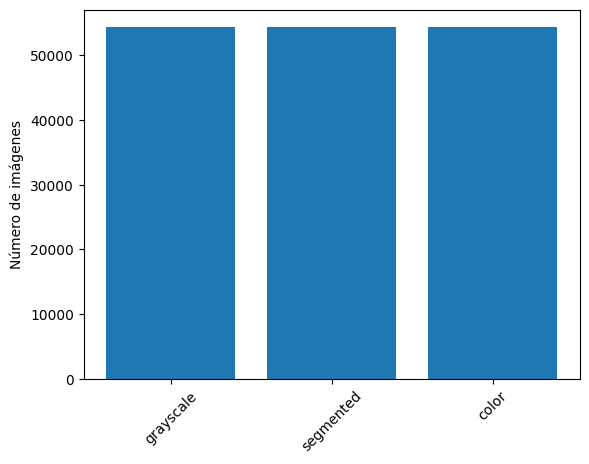

In [4]:
from collections import Counter

counts = Counter()
for cls_dir in local_dir.iterdir():
    if cls_dir.is_dir():
        img_files = [p for p in cls_dir.rglob("*.jpg")]
        n = len(img_files)  # ajusta la extensión si es necesario
        counts[cls_dir.name] = n

# Imprime y grafica
print(counts)
import matplotlib.pyplot as plt

plt.bar(counts.keys(), counts.values())
plt.ylabel("Número de imágenes")
plt.xticks(rotation=45)
plt.show()


**Algunas muestras aleatorias**

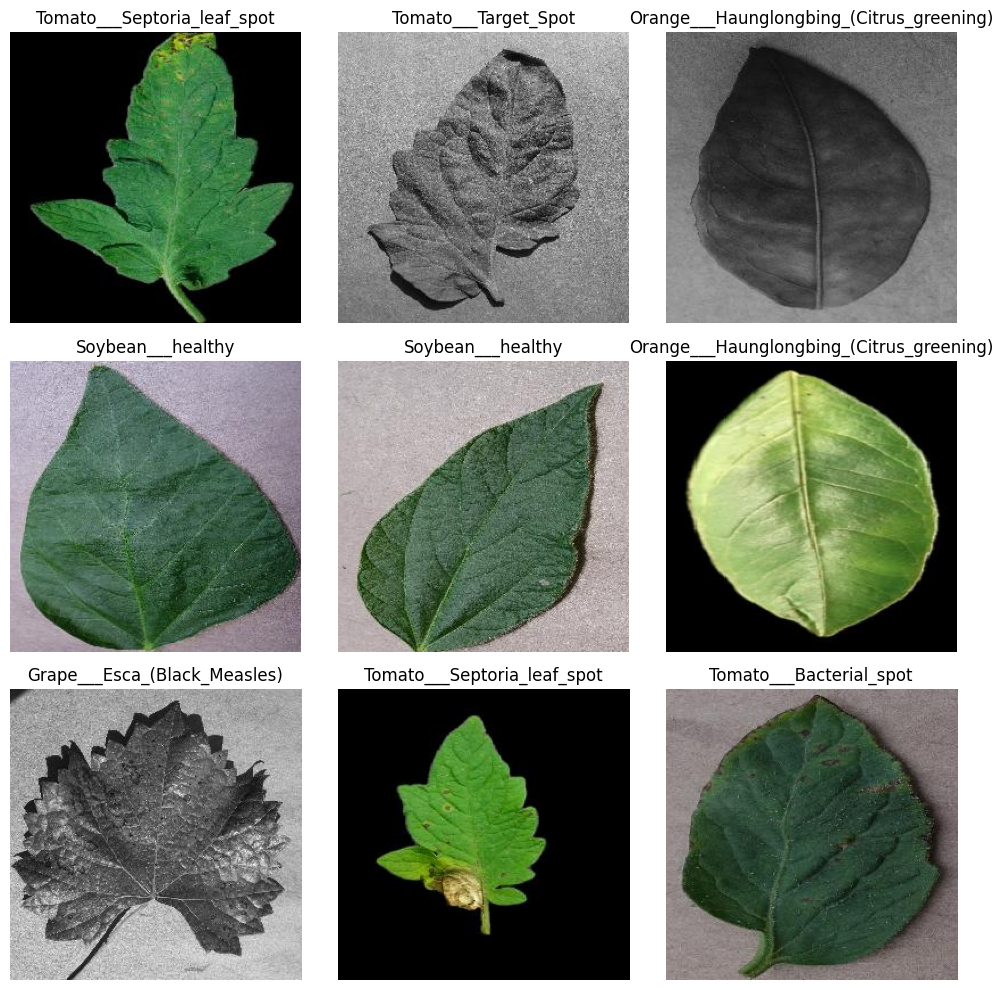

In [5]:
import random
import matplotlib.pyplot as plt
from PIL import Image

def show_random_samples(n=9):
    fig, axes = plt.subplots(int(n**0.5), int(n**0.5), figsize=(10,10))
    axes = axes.flatten()
    all_files = list(local_dir.rglob("*.jpg"))
    samples = random.sample(all_files, n)
    for ax, img_path in zip(axes, samples):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(img_path.parent.name)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

show_random_samples(9)

## Creación de un dataframe para organizar las imágenes

In [6]:
import pandas as pd
from pathlib import Path


base_dir   = local_dir


records = []
for cls_dir in base_dir.iterdir():
    if not cls_dir.is_dir():
        continue
    
    raw_label = cls_dir.name                # e.g. "Tomato___Late_blight"
    parts     = raw_label.split("___")      
    plant     = parts[0]                    # e.g. "Tomato"
    disease   = parts[1] if len(parts)>1 else "healthy"
    
    # Podrías añadir más parseos si el nombre incluye, por ejemplo,
    # subtipos o grado de severidad: parts = raw_label.split("___", maxsplit=2)
    
    for img_path in cls_dir.rglob("*"):
        if img_path.suffix.lower() == ".jpg":
            records.append({
                "path":       str(img_path),
                "raw_label":  raw_label,
                "plant":      plant,
                "disease":    disease,
                "is_outlier": False
            })


df = pd.DataFrame(records)

print(df.head())
print(df.groupby(["plant","disease"]).size().sort_values(ascending=False).head())


                                                path  raw_label      plant  \
0  plantvillage-dataset/grayscale/Corn_(maize)___...  grayscale  grayscale   
1  plantvillage-dataset/grayscale/Corn_(maize)___...  grayscale  grayscale   
2  plantvillage-dataset/grayscale/Corn_(maize)___...  grayscale  grayscale   
3  plantvillage-dataset/grayscale/Corn_(maize)___...  grayscale  grayscale   
4  plantvillage-dataset/grayscale/Corn_(maize)___...  grayscale  grayscale   

   disease  is_outlier  
0  healthy       False  
1  healthy       False  
2  healthy       False  
3  healthy       False  
4  healthy       False  
plant      disease
segmented  healthy    54306
color      healthy    54303
grayscale  healthy    54303
dtype: int64


## Correcciones de tamaños y radio de aspecto

Anchos:  256 (min), 256.0 (mediana), 256 (max)
Altos:   256 (min), 256.0 (mediana), 256 (max)


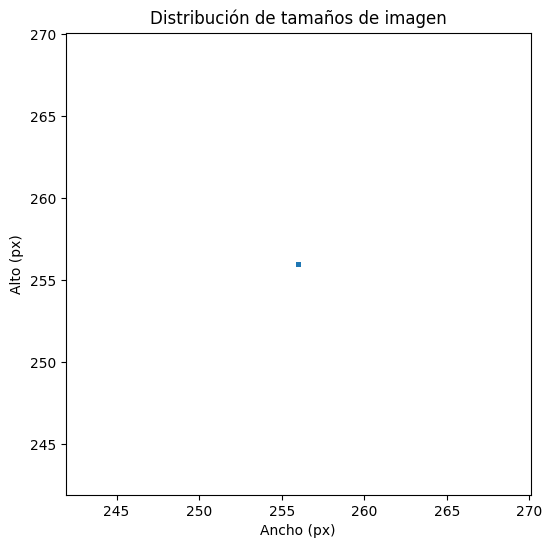

Aspect ratio: min= 1.0 mediana= 1.0 max= 1.0


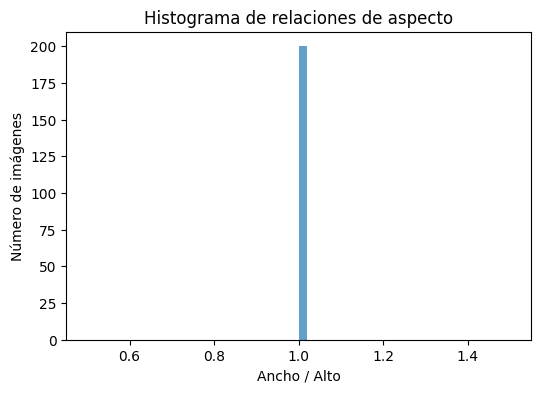

In [13]:
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


random.seed(42)
sample_paths = df["path"].sample(200, random_state=42).tolist()
widths, heights = [], []
for p in sample_paths:
    img = Image.open(p)
    w, h = img.size
    widths.append(w)
    heights.append(h)


print("Anchos: ", np.min(widths), "(min),", np.median(widths), "(mediana),", np.max(widths), "(max)")
print("Altos:  ", np.min(heights), "(min),", np.median(heights), "(mediana),", np.max(heights), "(max)")

# Scatter de width vs height
plt.figure(figsize=(6,6))
plt.scatter(widths, heights, s=5, alpha=0.6)
plt.xlabel("Ancho (px)")
plt.ylabel("Alto (px)")
plt.title("Distribución de tamaños de imagen")
plt.show()

# Relación de aspecto
aspects = np.array(widths) / np.array(heights)
print("Aspect ratio: min=", np.min(aspects), "mediana=", np.median(aspects), "max=", np.max(aspects))

# Histograma de relaciones de aspecto
plt.figure(figsize=(6,4))
plt.hist(aspects, bins=50, alpha=0.7)
plt.xlabel("Ancho / Alto")
plt.ylabel("Número de imágenes")
plt.title("Histograma de relaciones de aspecto")
plt.show()


No se observan variaciones en el redio de apecto ni en el tamaño, así no se modifican las imágenes en estas características

## Detección de outliers en el espacio de características
### 1. Análisis por t-SNE
Se toma una muestra de 300 imágenes al azar para evaluar los outliers mediante t-SNE

In [8]:
# Uncomment to install dependencies
# !pip install torch torchvision scikit-learn matplotlib

/home/gustavo/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gustavo/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


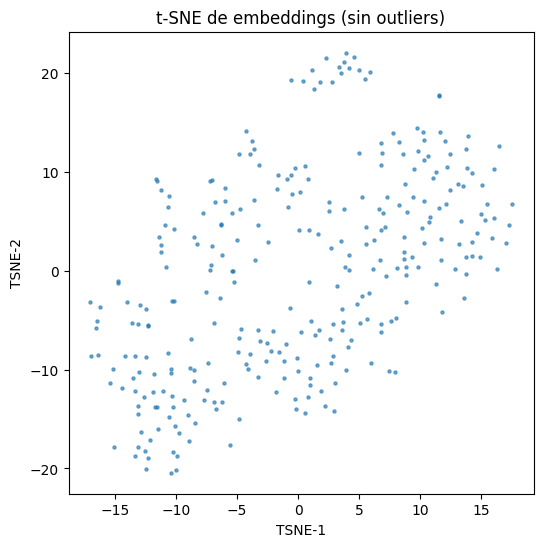

In [9]:
import random
import numpy as np
import pandas as pd
import torch
from sklearn.manifold import TSNE
import torchvision.models as models
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

model = models.resnet18(pretrained=True)
model.eval()
transform = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor()
])

sampled_paths = df["path"].sample(300, random_state=42).tolist()
embs = []
for p in sampled_paths:
    img = Image.open(p).convert("RGB")
    tensor = transform(img).unsqueeze(0)
    with torch.no_grad():
        emb = model(tensor).squeeze().numpy()
    embs.append(emb)
embs = np.stack(embs)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
proj = tsne.fit_transform(embs)

# scatter plot
plt.figure(figsize=(6,6))
plt.scatter(proj[:,0], proj[:,1], s=5, alpha=0.6)
plt.title("t-SNE de embeddings (sin outliers)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.show()


Detectados 8 outliers en total.
Total original: 162912, limpio: 162904


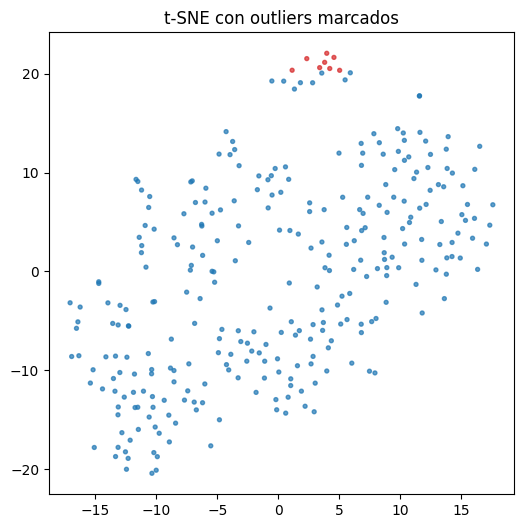

In [10]:

df_tsne = pd.DataFrame({
    "path": sampled_paths,
    "tsne1": proj[:,0],
    "tsne2": proj[:,1]
})

def mark_iqr_outlier(s, f=1.5):
    Q1, Q3 = s.quantile(0.25), s.quantile(0.75)
    IQR = Q3 - Q1
    return ~s.between(Q1 - f*IQR, Q3 + f*IQR)

def mark_std_outlier(s, t=2):
    return (s < s.mean()-t*s.std()) | (s > s.mean()+t*s.std())

df_tsne["out_x"] = mark_iqr_outlier(df_tsne["tsne1"])
df_tsne["out_y"] = mark_iqr_outlier(df_tsne["tsne2"])

if df_tsne["out_x"].sum()==0:
    df_tsne["out_x"] = mark_std_outlier(df_tsne["tsne1"])
if df_tsne["out_y"].sum()==0:
    df_tsne["out_y"] = mark_std_outlier(df_tsne["tsne2"])

df_tsne["is_outlier_tsne"] = df_tsne["out_x"] | df_tsne["out_y"]
print(f"Detectados {df_tsne.is_outlier_tsne.sum()} outliers en total.")


outs = set(df_tsne.loc[df_tsne.is_outlier_tsne, "path"])
df["is_outlier"] = df["path"].isin(outs)
df_clean = df[~df.is_outlier].reset_index(drop=True)
print(f"Total original: {len(df)}, limpio: {len(df_clean)}")

plt.figure(figsize=(6,6))
plt.scatter(df_tsne.tsne1, df_tsne.tsne2, 
            c=df_tsne.is_outlier_tsne.map({False:"C0", True:"C3"}), 
            s=8, alpha=0.7)
plt.title("t-SNE con outliers marcados")
plt.show()


### 2. Estadísticas de Pixel de las imágenes 
Análisis de los canles R,G,B para ver si hay alguna desviación estadística de los colores

R: mean=92.5, std=64.5, min=0, max=255
G: mean=99.6, std=65.3, min=0, max=255
B: mean=83.6, std=63.4, min=0, max=255


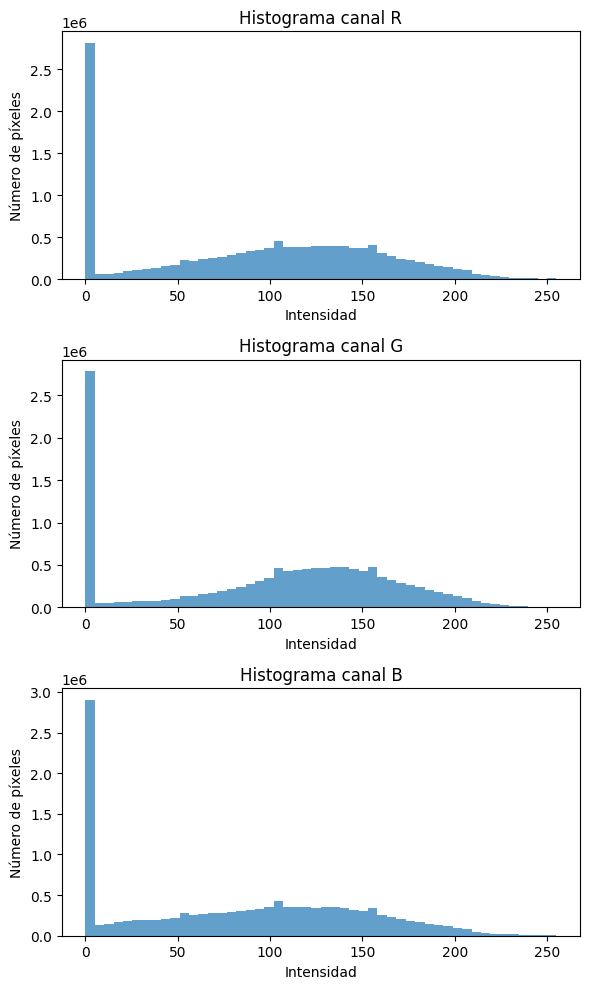

In [11]:
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

random.seed(42)
sample_paths = df["path"].sample(200, random_state=42).tolist()

pixels = []
for p in sample_paths:
    img = np.array(Image.open(p).convert("RGB"))
    pixels.append(img.reshape(-1, 3))

pixels = np.concatenate(pixels, axis=0)


for i, c in enumerate(["R","G","B"]):
    vals = pixels[:, i]
    print(f"{c}: mean={vals.mean():.1f}, std={vals.std():.1f}, min={vals.min()}, max={vals.max()}")


fig, axes = plt.subplots(3, 1, figsize=(6, 10))
for i, (ax, color) in enumerate(zip(axes, ["R", "G", "B"])):
    ax.hist(pixels[:, i], bins=50, alpha=0.7)
    ax.set_title(f"Histograma canal {color}")
    ax.set_xlabel("Intensidad")
    ax.set_ylabel("Número de píxeles")
plt.tight_layout()
plt.show()


No se aprecian grandes desviaciones respecto de la normal. No hace falta modificar nada.

In [12]:
df_clean.to_csv("dataset_clean.csv", index=False)
df_clean = pd.read_csv("dataset_clean.csv")
